In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import os
import random
import sys
from pathlib import Path

sns.set_theme(style='whitegrid')
%matplotlib inline

tp_root = '/home/facuvulcano/Machine-Learning/TP4/'
src_dir = os.path.join(tp_root, 'src')

if src_dir not in sys.path:
    sys.path.append(src_dir)
    
from datasets.cross_validation import cross_val

logs_dir = os.path.join(tp_root, 'src', 'train_test', 'logs')
results_dir = os.path.join(tp_root, 'results')
folds_dir = os.path.join(results_dir, 'folds')

os.makedirs(logs_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(folds_dir, exist_ok=True)

script_path = os.path.join(tp_root, 'main.py')
python_executable = '/home/facuvulcano/miniconda3/envs/ML/bin/python'
working_dir = os.path.dirname(script_path)

### 1.a) Implementacion de una red neuronal multicapa densa

**Objetivo:** Entrenar una red neuronal con 3 capas ocultas, con 10, 8 y 4 neuronas respectivamente, utilizando ReLU como funcion de activacion y unn learning rate 1e-8. Se evaluara el modelo en el conjunto de validacion utilizando metricas RMSE, MAE y R2, y se graficaran las curvas de error de entrenamiento y validacion.

Ejecutando entrenamiento de red neuronal..

Cantidad de capas ocultas: 3
Capa oculta: 1 tiene 10 neuronas 
Capa oculta: 2 tiene 8 neuronas 
Capa oculta: 3 tiene 4 neuronas 
Cantidad de parametros: 329
Tamanio del batch no especificado. Usando entrenamiento batch completo: 219
y_pred_norm_array: [0.42074617 0.4069353  0.42074617 0.42074617 0.4170193  0.40634091
 0.42074617 0.39409281 0.42074617 0.39613747 0.42074617 0.39542758
 0.42074617 0.41820398 0.40641901 0.42074617 0.40695738 0.39813453
 0.42074617 0.42074617 0.42074617 0.39935899 0.42074617 0.41684943
 0.42074617 0.3974978  0.42074617 0.42074617 0.42074617 0.42074617
 0.42074617 0.42074617 0.42074617 0.42074617 0.4170134  0.42074617
 0.42074617 0.42074617 0.42074617 0.42074617 0.42074617 0.42074617
 0.42074617 0.42074617 0.409922   0.42074617 0.41961237 0.41820511
 0.42074617 0.41820624 0.42074617 0.41630429 0.39775703 0.42074617]
ymax: 65000.0
ymin: 11500.0
[34009.92027343 33271.03866787 34009.92027343 34009.92027343
 33810.5325

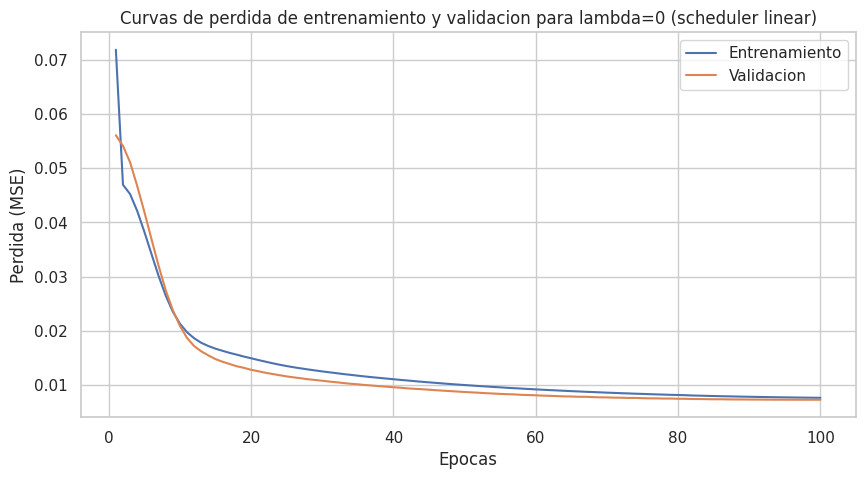

In [2]:
log_file_q1 = os.path.join(logs_dir, 'training_linear_lambda_0.log')
metrics_file_q1 = os.path.join(results_dir, 'evaluation_metrics_linear_lambda_0.csv')

command_1a = [
    python_executable,
    script_path,
    '--log_file', log_file_q1,
    '--metrics_file', metrics_file_q1,
    '--num_epochs', '100',
]

print("Ejecutando entrenamiento de red neuronal..")
result_1a = subprocess.run(command_1a, cwd=working_dir, capture_output=True, text=True)

print(result_1a.stdout)
print("Errores:")
print(result_1a.stderr)

metrics_1a = pd.read_csv(metrics_file_q1)
metrics_1a.head()

# Grafico de curvas de perdida de entrenamiento y validacion
plt.figure(figsize=(10, 5))
plt.plot(metrics_1a['Epoch'], metrics_1a['Train Loss'], label='Entrenamiento')
plt.plot(metrics_1a['Epoch'], metrics_1a['Val Loss'], label='Validacion')
plt.xlabel('Epocas')
plt.ylabel('Perdida (MSE)')
plt.title('Curvas de perdida de entrenamiento y validacion para lambda=0 (scheduler linear)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'loss_curves_linear_lambda_0.png'))
plt.show()

### **Analisis de resultados:**

Se puede observar que con un learning rate de 1e-8 utilizado durante el entrenamiento, el RMSE se mantiene muy alto y la loss se reduce muy lentamente a lo largo de las epocas. La red neuronal esta aprendiendo porque las metricas mejoran pero a una velocidad excesivamente lenta. Es necesario realizar modificaciones y mejoras para lograr que la red entrene de una mejor manera.

### 2. Implementacion de Learning Rate Scheduelrs

**Objetivo:** Implementar diferentes estrategias de ajuste dinnamico de la tasa de aprendizaje y comaparar el rendimiento del modelo para cada una. Las variantes a explorar son:

a) Linear decay
b) Power law
c) Exponential decay

Se debe graficar la evolucion del error en funcion de las epocas para cada scheduler.

In [3]:
scheduler_configs_q2 = {
    'linear' : {'final_lr' : 0.00001},
    'power' : {'power' : 0.5},
    'exponential' : {'decay_rate' : 0.9}
}

lambda_reg_q2 = 0.0

results_q2 = {}

for scheduler_type, params in scheduler_configs_q2.items():
    print(f'\nEntrenando con schedulers: {scheduler_type} y lambda={lambda_reg_q2}')

    log_file_q2 = os.path.join(logs_dir, f'training_{scheduler_type}_lambda_{lambda_reg_q2}.log')
    metrics_file_q2 = os.path.join(results_dir, f'evaluation_metrics_{scheduler_type}_lambda_{lambda_reg_q2}.csv')

    command_q2 = [
        python_executable,
        script_path,
        '--scheduler_type', scheduler_type,
        '--lambda_reg', str(lambda_reg_q2),
        '--log_file', log_file_q2,
        '--metrics_file', metrics_file_q2,
        '--num_epochs', '100',
        '--batch_size', '32'
    ]

    if scheduler_type == 'linear':
        command_q2 += ['--final_lr', str(params['final_lr']),
                       '--initial_learning_rate', "0.1"]
    elif scheduler_type == 'power':
        command_q2 += ['--power', str(params['power']),
                       '--initial_learning_rate', "0.01"]
    elif scheduler_type == 'exponential':
        command_q2 += ['--decay_rate', str(params['decay_rate']),
                       '--initial_learning_rate', "1"]

    result_q2 = subprocess.run(command_q2, cwd=working_dir, capture_output=True, text=True)

    print("Saldia estandar:")
    print(result_q2.stdout)
    print("Errores:")
    print(result_q2.stderr)

    if os.path.exists(metrics_file_q2):
        metrics_df_q2 = pd.read_csv(metrics_file_q2)
        results_q2[scheduler_type] = metrics_df_q2
    else:
        print(f'Archivo de metricas {metrics_file_q2} no encontrado.')


Entrenando con schedulers: linear y lambda=0.0
Saldia estandar:

Cantidad de capas ocultas: 3
Capa oculta: 1 tiene 10 neuronas 
Capa oculta: 2 tiene 8 neuronas 
Capa oculta: 3 tiene 4 neuronas 
Cantidad de parametros: 329
Tamanio del batch especificado: 32

Early stopping en la epoca 77
Train Loss=0.0036, Val Loss=0.0067, RMSE=4611.1609, MAE=3321.4484, R2=0.8624

Entrenamiento durante 77 epocas.
Resultados finales:
Train Loss=0.0036, Val Loss=0.0067, RMSE=4611.1609, MAE=3321.4484, R2=0.8624

Entrenamiento completado.
Metricas guardads en: /home/facuvulcano/Machine-Learning/TP4/results/evaluation_metrics_linear_lambda_0.0.csv

Errores:


Entrenando con schedulers: power y lambda=0.0
Saldia estandar:

Cantidad de capas ocultas: 3
Capa oculta: 1 tiene 10 neuronas 
Capa oculta: 2 tiene 8 neuronas 
Capa oculta: 3 tiene 4 neuronas 
Cantidad de parametros: 329
Tamanio del batch especificado: 32

Entrenamiento durante 100 epocas.
Resultados finales:
Train Loss=0.0095, Val Loss=0.0098, RMSE=55

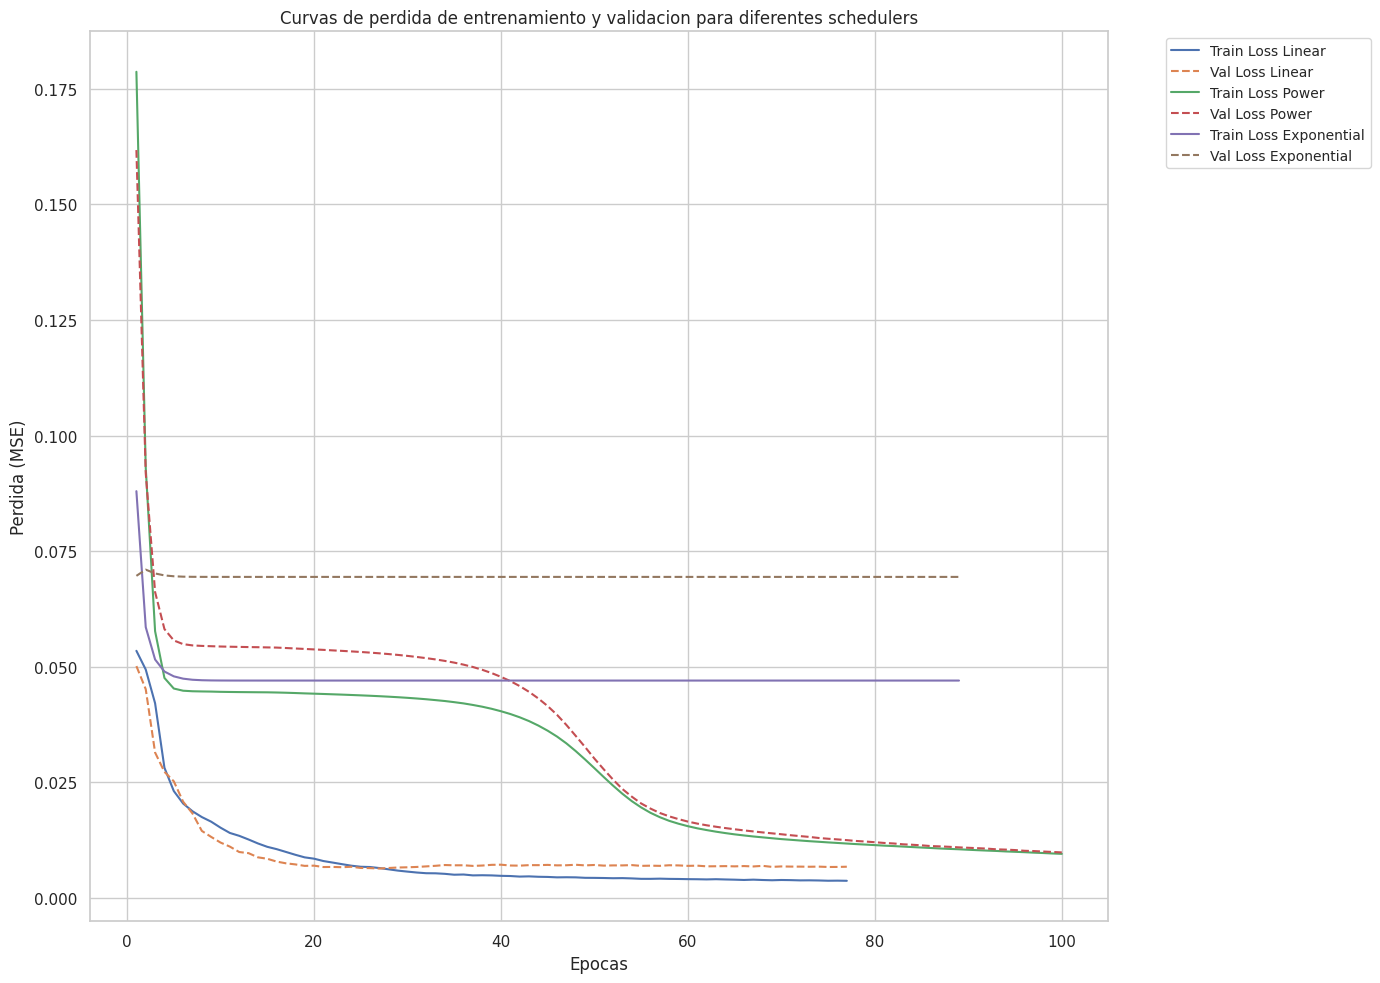

In [4]:
plt.figure(figsize=(14, 10))

for scheduler_type, metrics_df_q2 in results_q2.items():
    plt.plot(metrics_df_q2['Epoch'], metrics_df_q2['Train Loss'], label=f'Train Loss {scheduler_type.capitalize()}')
    plt.plot(metrics_df_q2['Epoch'], metrics_df_q2['Val Loss'], linestyle='--', label=f'Val Loss {scheduler_type.capitalize()}')

plt.xlabel('Epocas')
plt.ylabel('Perdida (MSE)')
plt.title('Curvas de perdida de entrenamiento y validacion para diferentes schedulers')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'loss_curves_schedulers.png'))
plt.show()


In [5]:
metrics_list = []

for scheduler_type, metrics_df_q2 in results_q2.items():
    final_metrics = metrics_df_q2.tail(1)
    metrics_list.append({
        'scheduler'  : scheduler_type.capitalize(),
        'R2' : final_metrics['R2'].values[0],
        'RMSE' : final_metrics['RMSE'].values[0],
        'MAE' : final_metrics['MAE'].values[0]
    })

metrics_consolidated_q2 = pd.DataFrame(metrics_list)

metrics_consolidated_q2

,scheduler,R2,RMSE,MAE
0,Linear,0.862400,4611.160862,3321.448353
1,Power,0.812661,5577.489908,4413.699252
2,Exponential,-0.001111,14094.337930,11147.723040


/tmp/ipykernel_5297/3607900952.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='scheduler', y='R2', data=metrics_consolidated_q2, palette='viridis')


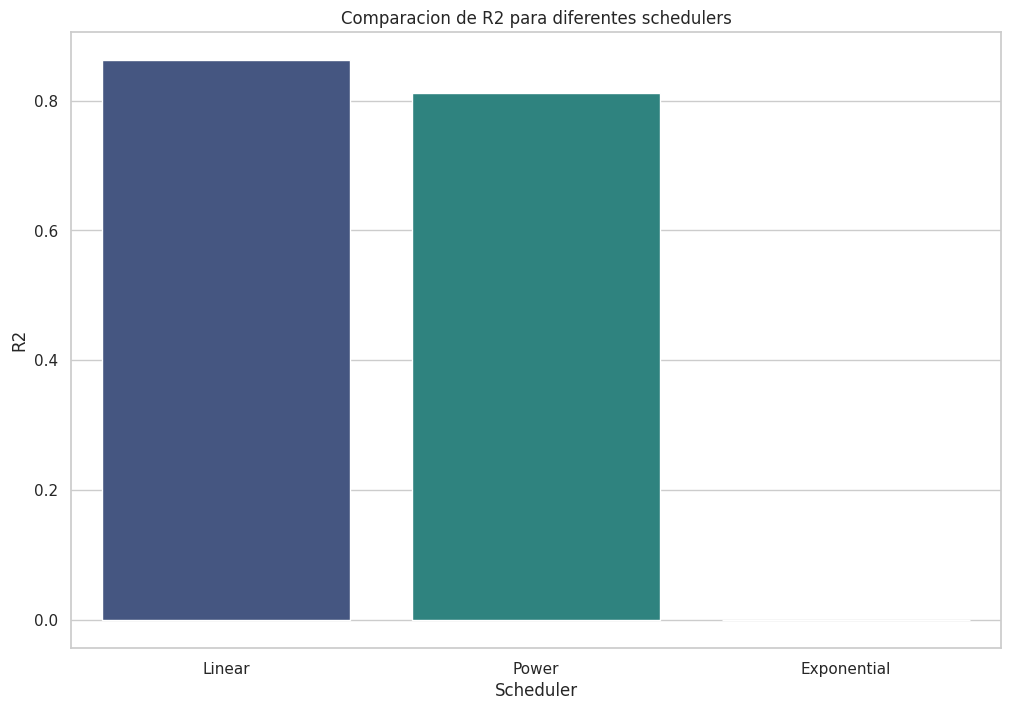

/tmp/ipykernel_5297/3607900952.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='scheduler', y='RMSE', data=metrics_consolidated_q2, palette='magma')


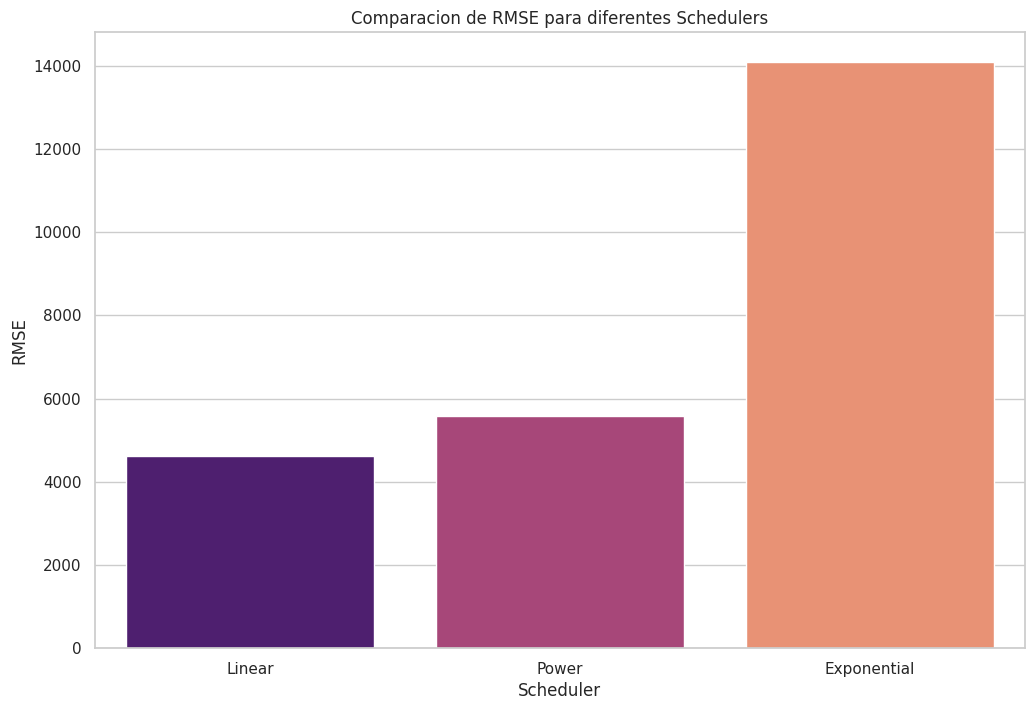

/tmp/ipykernel_5297/3607900952.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='scheduler', y='MAE', data=metrics_consolidated_q2, palette='plasma')


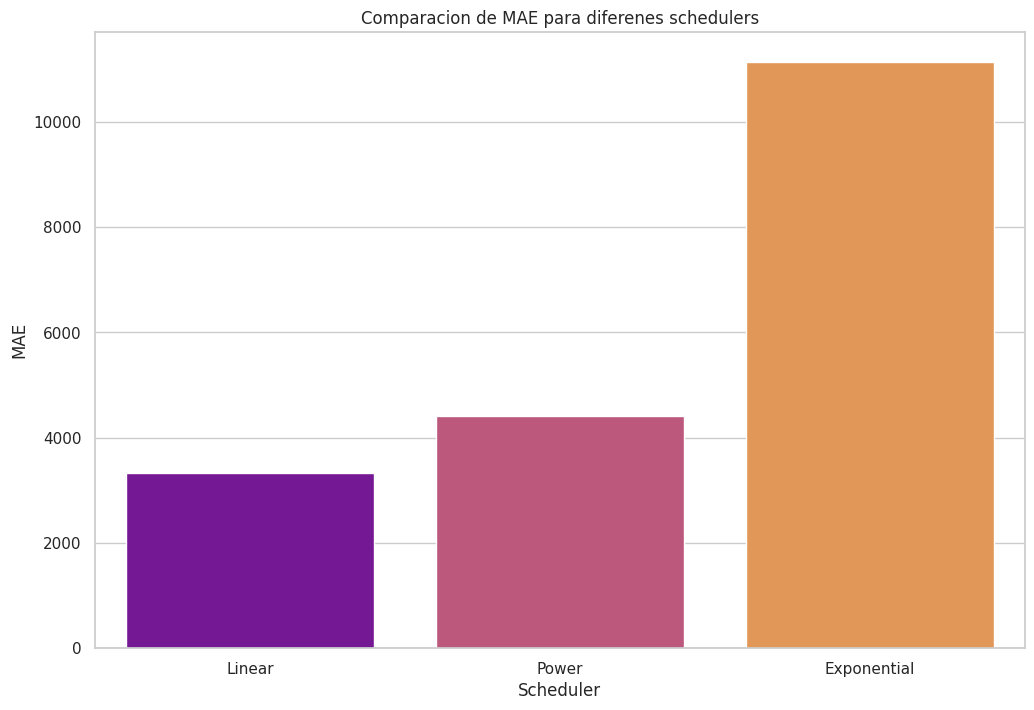

In [6]:
plt.figure(figsize=(12, 8))
sns.barplot(x='scheduler', y='R2', data=metrics_consolidated_q2, palette='viridis')
plt.title('Comparacion de R2 para diferentes schedulers')
plt.xlabel('Scheduler')
plt.ylabel('R2')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='scheduler', y='RMSE', data=metrics_consolidated_q2, palette='magma')
plt.title('Comparacion de RMSE para diferentes Schedulers')
plt.xlabel('Scheduler')
plt.ylabel('RMSE')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='scheduler', y='MAE', data=metrics_consolidated_q2, palette='plasma')
plt.title('Comparacion de MAE para diferenes schedulers')
plt.xlabel('Scheduler')
plt.ylabel('MAE')
plt.show()

### 3. Implementacion de Regularizacion L2

**Objetivo**: Implementar la tecnica de regularizacion L2 en la red neuronal para evitar el sobreajuste. Ajustar el hiperparametro de regularizacion lambda utilizando el conjunto de validacion. Mostrar graficos de eror de entrenamiento y validacion para distintos valores de lambda.

In [2]:
lambda_values_q3 = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

scheduler_type_q3 = 'linear'
results_q3 = {}

for lambda_reg in lambda_values_q3:
    print(f'\nEntrenando con scheduler={scheduler_type_q3} y lambda_reg={lambda_reg}')

    log_file_q3 = os.path.join(logs_dir, f'training_{scheduler_type_q3}_lambda_{lambda_reg}.log')
    metrics_file_q3 = os.path.join(results_dir, f'evaluation_metrics_{scheduler_type_q3}_lambda_{lambda_reg}.csv')

    command_q3 = [
        python_executable,
        script_path,
        '--scheduler_type', scheduler_type_q3,
        '--initial_learning_rate', "0.1",
        '--final_lr' , "0.00001",
        '--lambda_reg', str(lambda_reg),
        '--log_file', log_file_q3,
        '--metrics_file', metrics_file_q3,
        '--num_epochs', '100',
        '--batch_size', '32'
    ]

    result_q3 = subprocess.run(command_q3, cwd=working_dir, capture_output=True, text=True)

    print("Salida estandar:")
    print(result_q3.stdout)
    print("Errores:")
    print(result_q3.stderr)

    if os.path.exists(metrics_file_q3):
        try:
            metrics_df_q3 = pd.read_csv(metrics_file_q3)
            results_q3[lambda_reg] = metrics_df_q3

        except Exception as e:
            print(f'Error al leer el archivo de metricas {metrics_file_q3}: {e}')
    else:
         print(f"Archivo de metricas {metrics_file_q3} no encontrado")
    



Entrenando con scheduler=linear y lambda_reg=0


KeyboardInterrupt: 

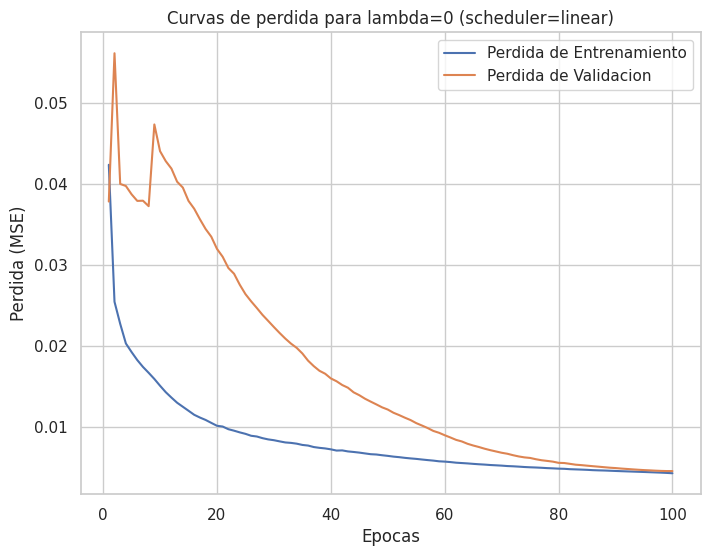

Grafico guardado en /home/facuvulcano/Machine-Learning/TP4/results/loss_curves_linear_lambda_0.png


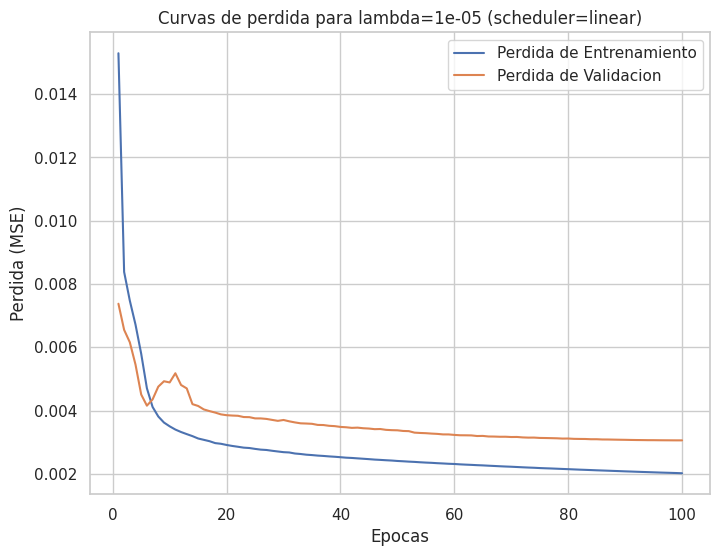

Grafico guardado en /home/facuvulcano/Machine-Learning/TP4/results/loss_curves_linear_lambda_1e-05.png


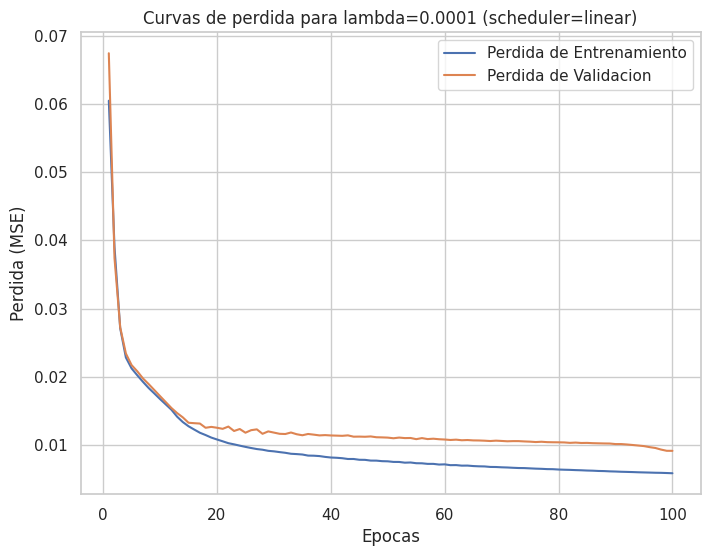

Grafico guardado en /home/facuvulcano/Machine-Learning/TP4/results/loss_curves_linear_lambda_0.0001.png


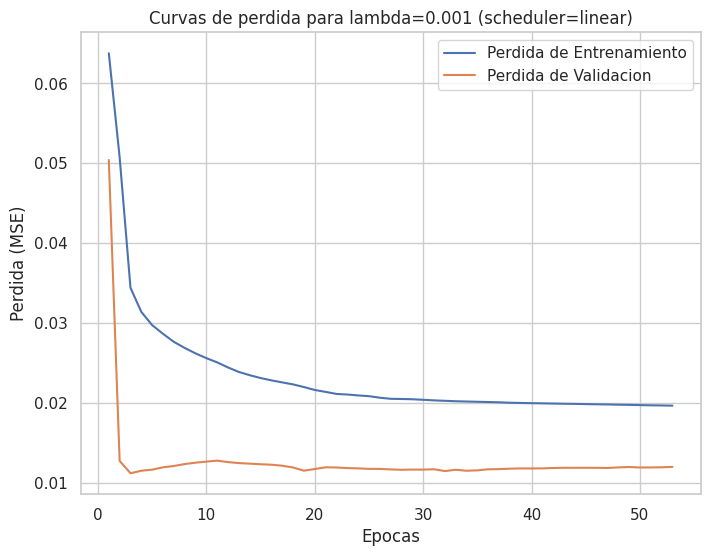

Grafico guardado en /home/facuvulcano/Machine-Learning/TP4/results/loss_curves_linear_lambda_0.001.png


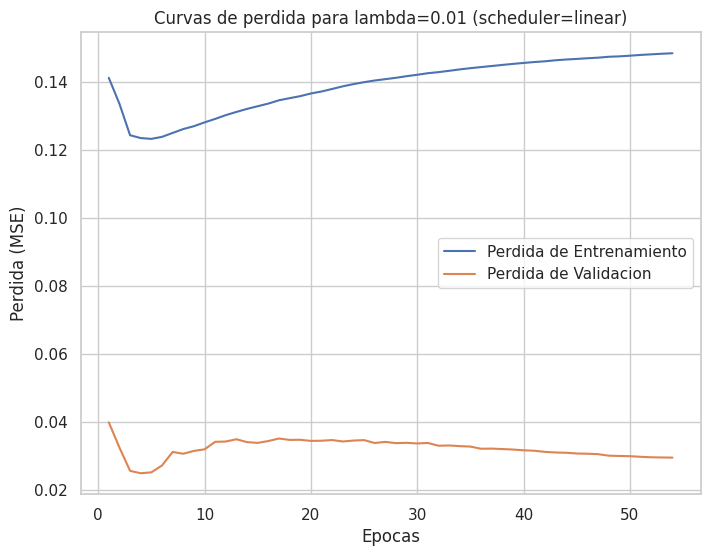

Grafico guardado en /home/facuvulcano/Machine-Learning/TP4/results/loss_curves_linear_lambda_0.01.png


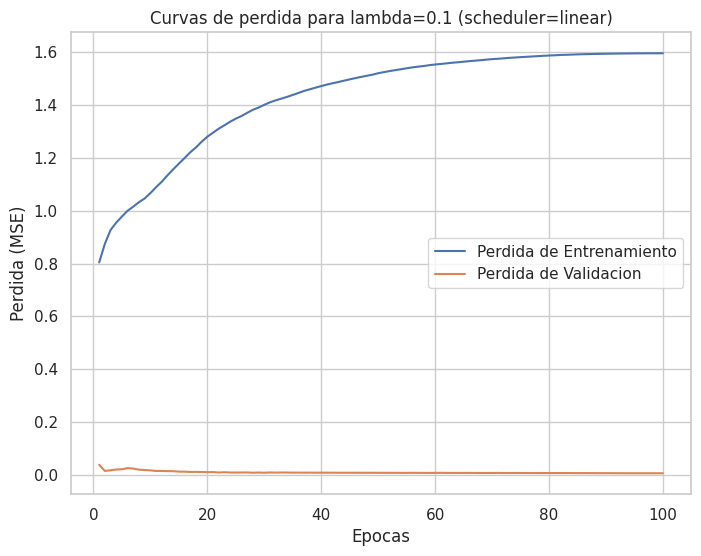

Grafico guardado en /home/facuvulcano/Machine-Learning/TP4/results/loss_curves_linear_lambda_0.1.png


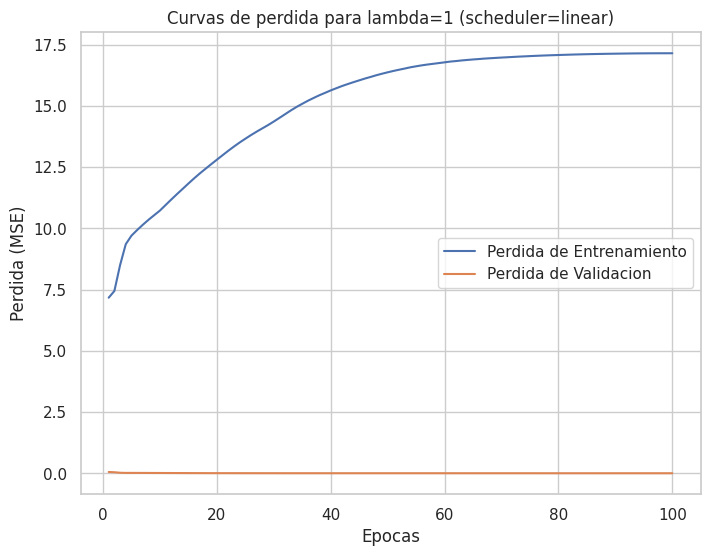

Grafico guardado en /home/facuvulcano/Machine-Learning/TP4/results/loss_curves_linear_lambda_1.png


In [8]:
if not results_q3:
    print('No hay metricas disponibles para graficar.')
else:
    for lambda_reg, metrics_df_q3 in results_q3.items():
        plt.figure(figsize=(8, 6))
        plt.plot(metrics_df_q3['Epoch'], metrics_df_q3['Train Loss'], label='Perdida de Entrenamiento')
        plt.plot(metrics_df_q3['Epoch'], metrics_df_q3['Val Loss'], label='Perdida de Validacion')
        plt.xlabel('Epocas')
        plt.ylabel('Perdida (MSE)')
        plt.title(f'Curvas de perdida para lambda={lambda_reg} (scheduler={scheduler_type_q3})')
        plt.legend()
        plt.grid(True)
        plot_filename = os.path.join(results_dir, f'loss_curves_{scheduler_type_q3}_lambda_{lambda_reg}.png')
        plt.savefig(plot_filename)
        plt.show()
        print(f'Grafico guardado en {plot_filename}')

### 4. Implementacion de distintos optimizadores

In [2]:
scheduler_type_q4 = 'linear'

optimizer_configs_q4 = {
    'adam' : {'learning_rate' : 0.01, 'beta1' : 0.9, 'beta2' : 0.999, 'epsilon' : 1e-8},
    'sgd' : {'learning_rate' : 0.1},
    'sgd_momentum' : {'learning_rate' : 0.1, 'momentum' : 0.9},
    'mini_batch_sgd' : {'learning_rate' : 0.1}
}

lambda_reg_q4 = 0

results_q4 = {}

for optimizer_type, params in optimizer_configs_q4.items():

    log_file_q4 = os.path.join(logs_dir, f'training_{optimizer_type}_lambda_{lambda_reg_q4}.log')
    metrics_file_q4 = os.path.join(results_dir, f'evaluation_metrics_{optimizer_type}_lambda_{lambda_reg_q4}.csv')

    command_q4 = [
        python_executable,
        script_path,
        '--optimizer', optimizer_type,
        '--scheduler_type', scheduler_type_q4,
        '--lambda_reg', str(lambda_reg_q4),
        '--log_file', log_file_q4,
        '--metrics_file', metrics_file_q4,
        '--num_epochs', '100', 
        '--final_lr', '0.00001',
        '--initial_learning_rate', str(params['learning_rate']),
        '--batch_size', '32'
    ]

    if optimizer_type == 'sgd_momentum':
        command_q4 += ['--momentum', str(params['momentum'])]
    elif optimizer_type == 'adam':
        command_q4 += [
            '--beta1', str(params['beta1']), 
            '--beta2', str(params['beta2']), 
            '--epsilon', str(params['epsilon'])
            ]

    print(f"Ejecutando entrenamiento con optimizador: {optimizer_type}... ")
    result_q4 = subprocess.run(command_q4, cwd=working_dir, capture_output=True, text=True)

    print("Salida estandar:")
    print(result_q4.stdout)
    print("Errores:")
    print(result_q4.stderr)

    if os.path.exists(metrics_file_q4):
        metrics_df_q4 = pd.read_csv(metrics_file_q4)
        results_q4[optimizer_type] = metrics_df_q4

        plt.figure(figsize=(10, 5))
        plt.plot(metrics_df_q4['Epoch'], metrics_df_q4['Train Loss'], label='Entrenamiento')
        plt.plot(metrics_df_q4['Epoch'], metrics_df_q4['Val Loss'], label='Validacion')
        plt.xlabel('Epocas')
        plt.ylabel('Perdida (MSE)')
        plt.title(f'Curvas de perdida para optimizador {optimizer_type} (lambda={lambda_reg_q4})')
        plt.legend()
        plt.grid(True)
        plot_filename = os.path.join(results_dir, f'loss_curves_{optimizer_type}_lambda_{lambda_reg_q4}.png')
        plt.savefig(plot_filename)
        plt.close()
        print(f"Grafico guardado en {plot_filename}")
    else:
        print(f'Archivo de metricas {metrics_file_q4} no encontrado.')



Ejecutando entrenamiento con optimizador: adam... 
Salida estandar:

Cantidad de capas ocultas: 3
Capa oculta: 1 tiene 10 neuronas 
Capa oculta: 2 tiene 8 neuronas 
Capa oculta: 3 tiene 4 neuronas 
Cantidad de parametros: 329
Tamanio del batch especificado: 32

Entrenamiento durante 100 epocas.
Resultados finales:
Train Loss=0.0040, Val Loss=0.0035, RMSE=3325.2056, MAE=2337.9782, R2=0.9326

Entrenamiento completado.
Metricas guardads en: /home/facuvulcano/Machine-Learning/TP4/results/evaluation_metrics_adam_lambda_0.csv

Errores:

Grafico guardado en /home/facuvulcano/Machine-Learning/TP4/results/loss_curves_adam_lambda_0.png
Ejecutando entrenamiento con optimizador: sgd... 
Salida estandar:

Cantidad de capas ocultas: 3
Capa oculta: 1 tiene 10 neuronas 
Capa oculta: 2 tiene 8 neuronas 
Capa oculta: 3 tiene 4 neuronas 
Cantidad de parametros: 329
Tamanio del batch especificado: 32

Entrenamiento durante 100 epocas.
Resultados finales:
Train Loss=0.0146, Val Loss=0.0117, RMSE=6102.0142,

In [3]:
# Figura 1: Perdida de Entrenamiento
plt.figure(figsize=(10, 6))
for optimizer_type, metrics_df_q4 in results_q4.items():
    plt.plot(metrics_df_q4['Epoch'], metrics_df_q4['Train Loss'], label=optimizer_type)
plt.xlabel('Epocas')
plt.ylabel('Perdidad de Entrenamiento (MSE)')
plt.title(f'Evolucion de la perdida de Entrenamiento para distintos optimizers (scheduelr={scheduler_type_q4})')
plt.legend()
plt.grid(True)
plot_filename_train = os.path.join(results_dir, f'train_loss_comparison_{scheduler_type_q4}.png')
plt.savefig(plot_filename_train)
plt.close()
print(f'Grafico de perdida de entrenamiento guardado en {plot_filename_train}')

# Figura 2: Perdida de Validacion
plt.figure(figsize=(10, 6))
for optimizer_type, metrics_df_q4 in results_q4.items():
    plt.plot(metrics_df_q4['Epoch'], metrics_df_q4['Val Loss'], label=optimizer_type)
plt.xlabel('Epocas')
plt.ylabel('Perdida de Validacion (MSE)')
plt.title(f'Evolucion de la perdida de validacion para distintos optimizers (scheduler={scheduler_type_q4})')
plt.legend()
plt.grid(True)
plot_filename_val = os.path.join(results_dir, f'val_loss_comparsion_{scheduler_type_q4}.png')
plt.savefig(plot_filename_val)
plt.close()
print(f'Grafico de perdida de validacion guardado en {plot_filename_val}')

Grafico de perdida de entrenamiento guardado en /home/facuvulcano/Machine-Learning/TP4/results/train_loss_comparison_linear.png
Grafico de perdida de validacion guardado en /home/facuvulcano/Machine-Learning/TP4/results/val_loss_comparsion_linear.png


### 5. Busqueda de hiperparametros

In [4]:
from datasets.preprocessing import processing

df = pd.read_csv('/home/facuvulcano/Machine-Learning/TP4/data/raw/toyota_dev.csv')
df_path = processing(df)
processed_df = pd.read_csv(df_path)

folds = 5
training_splits, validation_splits = cross_val(processed_df, 'Precio', folds)

print(training_splits)

for fold in range(folds):
    X_train, y_train = training_splits[fold]
    X_val, y_val = validation_splits[fold]

    train_data_path = os.path.join(folds_dir, f'fold{fold}_train')
    val_data_path = os.path.join(folds_dir, f'fold{fold}_val')

    train_df = X_train.copy()
    train_df['Precio'] = y_train
    train_df.to_csv(f'{train_data_path}.csv', index=False)

    val_df = X_val.copy()
    val_df['Precio'] = y_val
    val_df.to_csv(f'{val_data_path}.csv', index=False)

    print(f'Fold {fold}: Splits guardados correctamente.')

print("Splits de validacion cruzada generados y guardados correctamente.")

[(       Año  Kilómetros  Corolla Cross  Hilux SW4  RAV4  Diésel  Eléctrico  \
1259  2022      111111              0          1     0       1          0   
911   2023        8002              0          1     0       1          0   
961   2019       23000              0          1     0       1          0   
1124  2022       48000              0          1     0       1          0   
1017  2018      163000              0          1     0       1          0   
...    ...         ...            ...        ...   ...     ...        ...   
1326  2009      246000              0          0     1       0          0   
450   2022       27200              0          1     0       1          0   
675   2014      119700              0          0     1       0          0   
947   2022       25000              1          0     0       0          0   
855   2021       74000              0          1     0       1          0   

      Híbrido  Nafta  Nafta/GNC  ...  Manual  1  1.8  2.0  2.4  2.5  2.7 

In [5]:
scheduler_type_q5 = 'linear'
lambda_reg_q5 = 1e-5
L_values = [2, 3, 4] # Numero de capas ocultas
M_choices = [5, 10, 15, 20]  # Numero de neuronas por capa
n_iter_search = 5 #Numero de combinaciones aleatorias a probar

random.seed(42)
random_hyperparams = []

for _ in range(n_iter_search):
    L = random.choice(L_values)
    M_list = [random.choice(M_choices) for _ in range(L)]
    random_hyperparams.append({
        'L' : L,
        'M_list' : M_list
    })

print(f'Se han generado {n_iter_search} combinaciones aleatorias de hiperparametros.')
print(random_hyperparams)

Se han generado 5 combinaciones aleatorias de hiperparametros.
[{'L': 4, 'M_list': [5, 5, 15, 10]}, {'L': 2, 'M_list': [10, 5]}, {'L': 4, 'M_list': [5, 20, 5, 5]}, {'L': 2, 'M_list': [10, 10]}, {'L': 4, 'M_list': [5, 10, 20, 10]}]


In [8]:
results_q5 = []

for idx, hyperparams in enumerate(random_hyperparams):
    L = hyperparams['L']
    M_list = hyperparams['M_list']

    val_losses = []
    rmses = []
    maes = []
    r2s = []

    print(f'\n=== Evaluando combinacion {idx+1}/{n_iter_search} ===')
    print(f'Hiperparametros: L={L}, M_list={M_list}, lambda_reg={lambda_reg_q5}, scheduler_type={scheduler_type_q5}')


    for fold in range(folds):
        
        train_data_path = os.path.join(folds_dir, f'fold{fold}_train.csv')
        val_data_path = os.path.join(folds_dir, f'fold{fold}_val.csv')

        log_file_q5 = os.path.join(logs_dir, f'training_L{L}_M{"_".join(map(str, M_list))}_fold{fold}_lambda_{lambda_reg_q5}.log')
        metrics_file_q5 = os.path.join(results_dir, f'evaluation_metrics_L{L}_M{"_".join(map(str, M_list))}_fold{fold}_lambda_{lambda_reg_q5}.csv')
    

        command_q5 = [
            python_executable,
            script_path,
            '--optimizer', 'adam',
            '--beta1', '0.9',
            '--beta2', '0.999',
            '--epsilon', '1e-8',
            '--scheduler_type', scheduler_type_q5,
            '--lambda_reg', str(lambda_reg_q5),
            '--log_file', log_file_q5,
            '--metrics_file', metrics_file_q5,
            '--num_epochs', '100',
            '--final_lr', '0.00001',
            '--initial_learning_rate', '0.01',
            '--L', str(L),
            '--M_list', ','.join(map(str, M_list)),
            '--train_data', train_data_path,
            '--val_data', val_data_path,
            '--batch_size', '32'
        ]

        print(f"Fold {fold}: Entrenando...")
        result_q5 = subprocess.run(command_q5, cwd=working_dir, capture_output=True, text=True)

        print("salida estandar:")
        print(result_q5.stdout)
        print("Errores:")
        print(result_q5.stderr)

        if os.path.exists(metrics_file_q5):
            metrics_df_q5 = pd.read_csv(metrics_file_q5)
            final_val_loss = metrics_df_q5['Val Loss'].iloc[-1]
            final_rmse = metrics_df_q5['RMSE'].iloc[-1]
            final_mae = metrics_df_q5['MAE'].iloc[-1]
            final_r2 = metrics_df_q5['R2'].iloc[-1]
            
            val_losses.append(final_val_loss)
            rmses.append(final_rmse)
            maes.append(final_mae)
            r2s.append(final_r2)

            print(f'Fold {fold}: Val Loss={final_val_loss}, RMSE={final_rmse}, MAE={final_mae}, R2={final_r2}')
        else:
            print(f'Archivo de metricas {metrics_file_q5} no encontrado')
            val_losses.append(np.inf)
            rmses.append(np.inf)
            maes.append(np.inf)
            r2s.append(-np.inf)
        
    avg_val_loss = np.mean(val_losses)
    avg_rmse = np.mean(rmses)
    avg_mae = np.mean(maes)
    avg_r2 = np.mean(r2s)

    results_q5.append({
        'L' : L,
        'M_list' : M_list,
        'lambda_reg' : lambda_reg_q5,
        'scheduler_type' : scheduler_type_q5,
        'Avg Val Loss' : avg_val_loss,
        'RMSECV' : avg_mae,
        'MAECV' : avg_mae,
        'R2CV' : avg_r2
    })
    print(f'Hiperparametros L={L}, M_list={M_list}, lambda_reg={lambda_reg_q5}, scheduler_type={scheduler_type_q5} - '
          f'perdida de validacion promedio: {avg_val_loss}, RMSECV: {avg_rmse}, MAECV: {avg_mae}, R2CV: {avg_r2}')




=== Evaluando combinacion 1/5 ===
Hiperparametros: L=4, M_list=[5, 5, 15, 10], lambda_reg=1e-05, scheduler_type=linear
Fold 0: Entrenando...
salida estandar:

Cantidad de capas ocultas: 4
Capa oculta: 1 tiene 5 neuronas 
Capa oculta: 2 tiene 5 neuronas 
Capa oculta: 3 tiene 15 neuronas 
Capa oculta: 4 tiene 10 neuronas 
Cantidad de parametros: 401
Tamanio del batch especificado: 32

Entrenamiento durante 100 epocas.
Resultados finales:
Train Loss=0.0024, Val Loss=0.0013, RMSE=3596.0093, MAE=2559.1605, R2=0.9201

Entrenamiento completado.
Metricas guardads en: /home/facuvulcano/Machine-Learning/TP4/results/evaluation_metrics_L4_M5_5_15_10_fold0_lambda_1e-05.csv

Errores:

Fold 0: Val Loss=0.0012774333431661, RMSE=3596.0092991274832, MAE=2559.1605276522523, R2=0.9200767542873388
Fold 1: Entrenando...
salida estandar:

Cantidad de capas ocultas: 4
Capa oculta: 1 tiene 5 neuronas 
Capa oculta: 2 tiene 5 neuronas 
Capa oculta: 3 tiene 15 neuronas 
Capa oculta: 4 tiene 10 neuronas 
Cantidad

In [ ]:
results_df_q5 = pd.DataFrame(results_q5)
results_df_q5.to_csv(os.path.join(results_dir, 'hyperparameter_search_results.csv'), index=False)

weight_complexity = 1e-4
results_df_q5['Num Params'] = results_df_q5.apply(lambda row: row['L'] * sum(row['M_list']), axis=1)
results_df_q5['Composite Metric'] = results_df_q5.apply(
    lambda row : row['Avg Val Loss'] + weight_complexity * row['Num Params'], axis=1
)

best_hyperaparms = results_df_q5.loc[results_df_q5['Composite Metric'].idxmin()]
print("\nMejores hiperparametros encontrados (balance entre desempenio y complejidad):")
print(best_hyperaparms)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=results_df_q5,
    x='L',
    y='M_list',
    size='Avg Val Loss',
    hue='Avg Val Loss',
    palette='viridis',
    sizes=(100, 400)
)

plt.title('Busqueda de Hiperparametros (Random Search) - Neuronas Variables por Capa')
plt.xlabel('Numero de Capas Ocultas (L)')
plt.ylabel('Lista de Neuronas por capa (M_list)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'hyperparameter_search_scatter.png'))

## 6:

In [3]:
from datasets.preprocessing import processing

best_hyperparams_q6 = {
    'L' : 0,
    'M_list' : 0,
    'lambda_reg' : 1e-5,
    'scheduler_type' : 'linear'
}


L = best_hyperparams_q6['L']
m_list = best_hyperparams_q6['M_list']
lambda_reg = best_hyperparams_q6['lambda_reg']
scheduler = best_hyperparams_q6['scheduler_type']
optimizer = 'adam'

results_q6 = []
        
df = pd.read_csv('/home/facuvulcano/Machine-Learning/TP4/data/raw/toyota_dev.csv')
df_path = processing(df)
processed_df = pd.read_csv(df_path)

log_file_q6 = os.path.join(logs_dir, f'training_L{L}_M{"_".join(map(str, M_list))}_scheduler_{scheduler}_lambda_{lambda_reg}_optimizer_{optimizer}.log')
metrics_file_q6 = os.path.join(results_dir, f'evaluation_metrics_L{L}_M{"_".join(map(str, M_list))}_scheduler_{scheduler}_lambda_{lambda_reg_q5}_optimizer_{optimizer}.csv')

command_q6 = [
    python_executable,
    script_path,
    '--optimizer', optimizer,
    '--beta1', '0.9',
    '--beta2', '0.999',
    '--epsilon', '1e-8',
    '--scheduler_type', scheduler_type_q5,
    '--lambda_reg', str(lambda_reg_q5),
    '--log_file', log_file_q5,
    '--metrics_file', metrics_file_q5,
    '--num_epochs', '100',
    '--final_lr', '0.00001',
    '--initial_learning_rate', '0.01',
    '--L', str(L),
    '--M_list', ','.join(map(str, M_list)),
    '--train_data', train_data_path,
    '--val_data', val_data_path,
    '--batch_size', '32',
    '--train_data', processed_df
]

print(f'Ejecutando entrenamiento..')
result_q6 = subprocess.run(command_q6, cwd=working_dir, capture_output=True, text=True)

print("salida estandar:")
print(result_q6.stdout)
print("Errores:")
print(result_q6.stderr)




NameError: name 'M_list' is not defined